#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14B Predicting AirBnB apartment prices: selecting a regression model**

using the airbnb dataset

version 1.0 2022-10-06

In [1]:
import os
import sys
import warnings

import numpy as np
import patchworklib as pw
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *

warnings.filterwarnings("ignore")


No module named 'seaborn'


<Figure size 100x100 with 0 Axes>

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]
# location folders
data_in = dirname + "da_data_repo/airbnb/clean/"
data_out = dirname + "da_case_studies/ch14-airbnb-reg/"
output = dirname + "da_case_studies/ch14-airbnb-reg/output/"
func = "../ch00-tech-prep/"
sys.path.append(func)


from py_helper_functions import *

### Part 1

In [3]:
data = pd.read_csv("airbnb_hackney_workfile_adj_book1.csv")

Quick look at data

In [4]:
data.describe()

,usd_cleaning_fee,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
count,2769.000000,4496.000000,2970.000000,4496.000000,4487.000000,3073.000000,4496.000000,4496.000000,3147.000000,4496.000000,...,4487.000000,4496.000000,4495.000000,3146.000000,3146.000000,3146.000000,3.147000e+03,3.147000e+03,3073.000000,4495.000000
mean,31.439870,80.556940,90.924579,2.864324,1.225986,93.323788,10.141904,1.385454,0.946295,5.991770,...,1.150435,1.414416,0.745050,5.813246,34.920619,214.912424,4.386975e+05,5.008933e+08,4.529253,2.029366
std,25.871418,58.915794,21.642376,1.722148,0.480064,9.133501,22.342473,0.996658,1.143208,11.255617,...,0.379318,1.318117,0.529467,1.061670,11.357470,96.884368,6.959114e+05,1.179754e+09,0.130507,0.838032
min,4.000000,10.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,15.000000,40.000000,96.000000,2.000000,1.000000,90.000000,0.000000,1.000000,0.210000,0.000000,...,1.000000,0.000000,0.000000,5.269144,27.763878,146.291911,3.763600e+04,7.301384e+06,4.499810,1.000000
50%,25.000000,65.000000,100.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,...,1.000000,1.098612,1.000000,6.006350,36.076248,216.686649,1.640250e+05,6.643012e+07,4.564348,2.000000
75%,40.000000,100.000000,100.000000,4.000000,1.500000,100.000000,10.000000,1.000000,1.190000,10.000000,...,1.000000,2.397895,1.000000,6.512487,42.412491,276.210824,4.529300e+05,3.048232e+08,4.605170,3.000000
max,500.000000,850.000000,100.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,...,2.000000,5.673323,2.000000,7.773594,60.428771,469.748759,5.650129e+06,1.343036e+10,4.605170,3.000000


where do we have missing variables now?

In [5]:
data.isnull().sum().loc[lambda x: x > 0]

usd_cleaning_fee           1727
p_host_response_rate       1526
n_bathrooms                   9
n_review_scores_rating     1423
n_reviews_per_month        1349
n_beds                       12
n_days_since               1349
ln_beds                      12
f_bathroom                    9
f_number_of_reviews           1
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
f_minimum_nights              1
dtype: int64

What to do with missing values?

   1. drop if no target (already did)

In [6]:
data = data.dropna(subset=["price"])

 2. imput when few, not that important

In [7]:
data["n_bathrooms"] = data["n_bathrooms"].fillna(np.nanmedian(data["n_bathrooms"]))
data["n_beds"] = data["n_beds"].fillna(data["n_accommodates"])
data["f_bathroom"] = data["f_bathroom"].fillna(1)
data["f_minimum_nights"] = data["f_minimum_nights"].fillna(1)
data["f_number_of_reviews"] = data["f_number_of_reviews"].fillna(1)
data["ln_beds"] = data["ln_beds"].fillna(0)


In [8]:
data["n_bathrooms"].describe()


count    4496.000000
mean        1.225534
std         0.479690
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         8.000000
Name: n_bathrooms, dtype: float64

 3. drop columns when many missing not imortant

In [9]:
data = data.drop(["usd_cleaning_fee", "p_host_response_rate"], axis=1)


 where do we have missing variables now?

In [10]:
data.isnull().sum().loc[lambda x: x > 0]

n_review_scores_rating     1423
n_reviews_per_month        1349
n_days_since               1349
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

 4. Replace missing variables re reviews with zero, when no review + add flags

In [11]:
for var in ["flag_days_since", "flag_review_scores_rating", "flag_reviews_per_month"]:
    data[var] = [int(x) for x in data[var.replace("flag", "n")].isna()]

In [12]:
data["n_days_since"] = data["n_days_since"].fillna(np.nanmedian(data["n_days_since"]))
data["n_review_scores_rating"] = data["n_review_scores_rating"].fillna(
    np.nanmedian(data["n_review_scores_rating"])
)
data["n_reviews_per_month"] = data["n_reviews_per_month"].fillna(
    np.nanmedian(data["n_reviews_per_month"])
)


In [13]:
data.flag_days_since.value_counts()


0    3147
1    1349
Name: flag_days_since, dtype: int64

Add features -> different functional forms

Create variables, measuring the time since: squared, cubic, logs


In [14]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
).assign(
    ln_days_since=lambda x: np.where(
        x["ln_days_since"].isnull(), 0, x["ln_days_since"]
    ),
    ln_days_since2=lambda x: np.where(
        x["ln_days_since2"].isnull(), 0, x["ln_days_since2"]
    ),
    ln_days_since3=lambda x: np.where(
        x["ln_days_since3"].isnull(), 0, x["ln_days_since3"]
    ),
)

Look at data

In [15]:
data.describe()


,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights,flag_days_since,flag_review_scores_rating,flag_reviews_per_month
count,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,...,4496.000000,4496.000000,4496.000000,4.496000e+03,4.496000e+03,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000
mean,80.556940,2.864324,1.225534,94.170819,10.141904,1.385454,0.818387,5.991770,3.127002,1.577847,...,5.874549,35.296294,215.650102,3.562836e+05,3.705350e+08,4.540361,2.029137,0.300044,0.316504,0.300044
std,58.915794,1.722148,0.479690,7.652561,22.342473,0.996658,0.976154,11.255617,6.160668,1.044372,...,0.886647,9.482548,80.906146,5.956503e+05,1.006861e+09,0.109118,0.838079,0.458328,0.465164,0.458328
min,10.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000,0.000000,0.000000,0.000000
25%,40.000000,2.000000,1.000000,93.000000,0.000000,1.000000,0.330000,0.000000,1.000000,1.000000,...,5.551989,30.824581,171.137760,6.592075e+04,1.692525e+07,4.532599,1.000000,0.000000,0.000000,0.000000
50%,65.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,2.000000,1.000000,...,6.006353,36.076278,216.686868,1.640250e+05,6.643012e+07,4.564348,2.000000,0.000000,0.000000,0.000000
75%,100.000000,4.000000,1.500000,98.000000,10.000000,1.000000,0.860000,10.000000,3.000000,2.000000,...,6.335054,40.132912,254.244177,3.169690e+05,1.784535e+08,4.584967,3.000000,1.000000,1.000000,1.000000
max,850.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,180.000000,16.000000,...,7.774015,60.435310,469.825014,5.650129e+06,1.343036e+10,4.605170,3.000000,1.000000,1.000000,1.000000


 where do we have missing variables now?

In [16]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

### Business logic - define our prediction problem

Decision

Size, we need a normal apartment, 1-7persons

In [17]:
data = data.loc[data.n_accommodates < 8]


In [18]:
data.to_csv("airbnb_hackney_work.csv", index=False)


### Look at some descriptive statistics

How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?

In [19]:
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("price", np.mean))


mean_price
f_property_type f_room_type                
Apartment       Entire home/apt  106.364341
                Private room      48.034439
                Shared room       50.708333
House           Entire home/apt  134.794118
                Private room      42.931487
                Shared room       38.666667

In [20]:
data.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean))


,mean_price
f_bed_type,
Couch,49.091954
Real Bed,77.838365


In [21]:
data.price.describe()


count    4393.000000
mean       77.269064
std        53.265471
min        10.000000
25%        40.000000
50%        65.000000
75%        99.000000
max       850.000000
Name: price, dtype: float64

 NB all graphs, we exclude  extreme values of price

In [22]:
datau = data.loc[data.price < 400]


Histograms price

Distribution of price by type below 400

### Figure 14.3 Airbnb apartment price and ln price distributions.

(a) Price

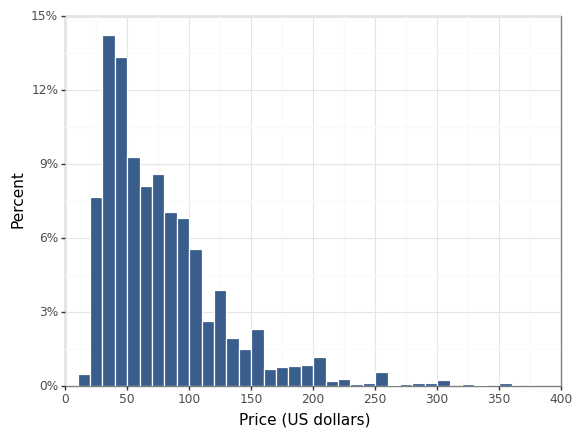

<ggplot: (674673399)>

In [23]:
(
    ggplot(datau, aes(x="price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=10,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + labs(x="Price (US dollars)", y="Percent")
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
)


(b) Price in log

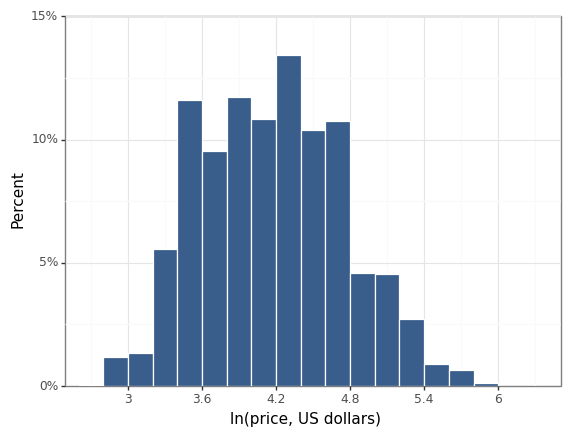

<ggplot: (674764042)>

In [24]:
(
    ggplot(datau, aes(x="ln_price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.2,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x="ln(price, US dollars)", y="Percent")
    + theme_bw()
)


### Figure 14.4 Airbnb apartment price distribution by important features

(a) Price by room type

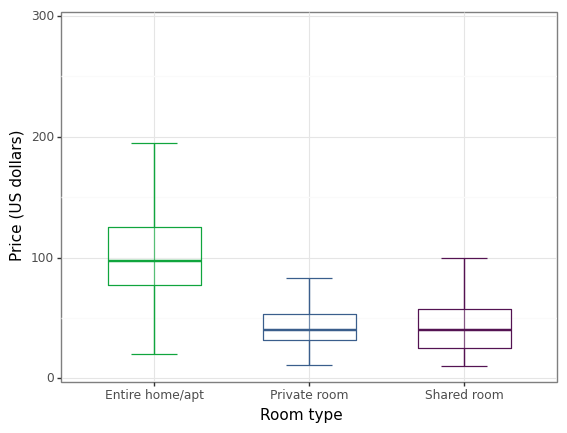

<ggplot: (674875667)>

In [25]:
(
    ggplot(datau, aes(x="f_room_type", y="price"))
    + stat_boxplot(
        aes(group="f_room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="f_room_type"),
        color=(color[1], color[0], color[2]),
        #fill=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_color="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)


(b) Price by number of people accommodated and apartment versus house in US dollars

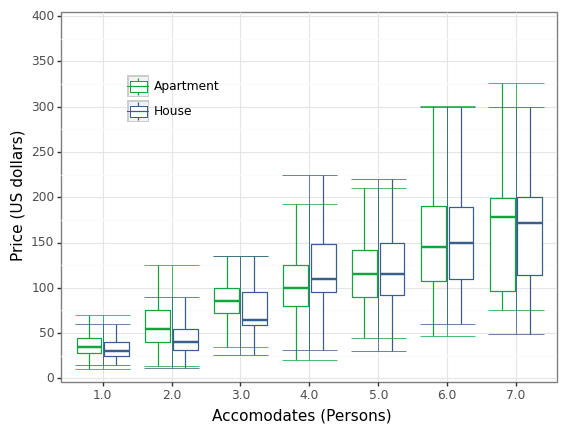

<ggplot: (674930405)>

In [26]:
(
    ggplot(
        datau,
        aes(
            x="factor(n_accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(f_property_type)",
        ),
    )
    + geom_boxplot(na_rm=True, outlier_color="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(values=(color[1], color[0]))
    # + scale_fill_manual(name=" ", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(
        legend_position=(0.3, 0.7),
        legend_title=element_blank(),
        legend_direction="vertical",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)

### Part2

In [27]:
data = pd.read_csv("airbnb_hackney_work.csv")

### Setting up models

Basic variables

In [28]:
basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_days_since",
    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy", "f_bed_type")
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = tuple(list(data.filter(regex="^d_.*")))


### Look for interactions

In [29]:
## Helper function
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

Room type

In [30]:
p1 = price_diff_by_variables(
    data, "f_room_type", "d_familykidfriendly", "Room type", "Family kid friendly"
)
p2 = price_diff_by_variables(
    data, "f_room_type", "f_property_type", "Room type", "Property type"
)

Look up canelation policy


In [31]:
p3 = price_diff_by_variables(
    data,
    "f_cancellation_policy",
    "d_familykidfriendly",
    "Cancellation policy",
    "Family kid friendly",
)
p4 = price_diff_by_variables(
    data, "f_cancellation_policy", "d_tv", "Cancellation policy", "TV"
)

Look up property type

In [32]:
p5 = price_diff_by_variables(data, "f_property_type", "d_cats", "Property type", "Cats")

p6 = price_diff_by_variables(data, "f_property_type", "d_dogs", "Property type", "Dogs")

In [33]:
g1 = pw.load_ggplot(p1, figsize=(3, 3))
g2 = pw.load_ggplot(p2, figsize=(3, 3))
g3 = pw.load_ggplot(p3, figsize=(3, 3))
g4 = pw.load_ggplot(p4, figsize=(3, 3))
g5 = pw.load_ggplot(p5, figsize=(3, 3))
g6 = pw.load_ggplot(p6, figsize=(3, 3))

interactions = (g1 | g2) / (g3 | g4 ) / (g5 | g6)

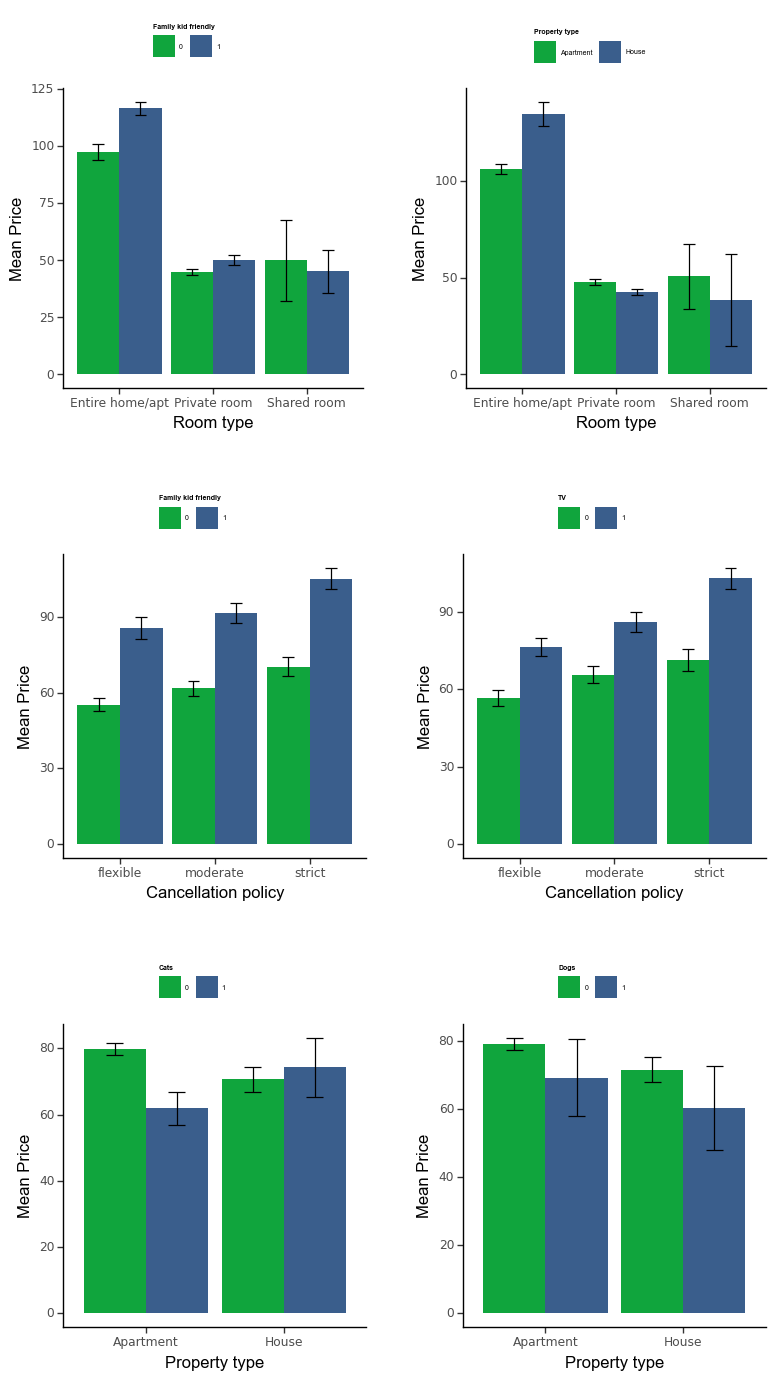

In [34]:
interactions.savefig()

Dummies suggested by graphs

In [35]:
X1 = ("f_room_type*f_property_type", "f_room_type*d_familykidfriendly")

 Additional interactions of factors and dummies

In [36]:
X2 = (
    "d_airconditioning*f_property_type",
    "d_cats*f_property_type",
    "d_dogs*f_property_type",
)
X3 = (
    "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * ("
    + "+".join(amenities)
    + ")"
)


Create estimation equations

In [37]:
modellev1 = "~ n_accommodates"
modellev2 = "~" + " + ".join(basic_lev)
modellev3 = "~" + " + ".join(basic_lev + basic_add + reviews)
modellev4 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev)
modellev5 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1)
modellev6 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2)
modellev7 = "~" + " + ".join(
    basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities
)
modellev8 = (
    "~"
    + "+".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities)
    + "+"
    + X3
)

### Create separate holdout set

In [38]:
sample_size = round(0.2 * data.shape[0]) - 1

 Set the random number generator: It will make results reproducable

In [39]:
np.random.seed(20180123)

In [40]:
from sklearn.model_selection import train_test_split

data_work, data_holdout = train_test_split(data, test_size=sample_size)

### Crossvalidation

Use custom function `ols_crossvalidator` for cross validation

In [41]:
help(ols_crossvalidator)

Help on function ols_crossvalidator in module py_helper_functions:

ols_crossvalidator(formula: str, data: pandas.core.frame.DataFrame, n_folds=5, average_rmse=True) -> dict
    OLS cross-validator
    
    
    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.
    
    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data: pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse: bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.



Set number of folds

In [42]:
n_folds = 5

Cross validate for each model and save results in `cv_list`

In [43]:
cv_list = []
for model in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [ols_crossvalidator("price" + model, data_work, n_folds)]

### Table 14.3 Comparing model fit measures

In [44]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,2,0.40,36132,41.18,40.96
1,M2,8,0.48,35703,38.46,38.23
2,M3,15,0.51,35563,37.38,37.26
3,M4,18,0.51,35551,37.18,37.15
4,M5,23,0.52,35575,37.09,37.07
5,M6,29,0.52,35607,36.99,37.03
6,M7,74,0.54,35775,35.92,36.49
7,M8,310,0.57,37458,34.45,38.71


### Figure 14.7 Training and test set RMSE for the eight regression models

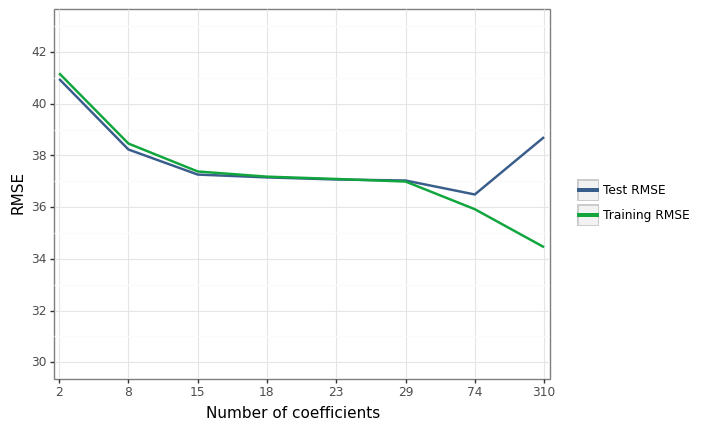

<ggplot: (677479599)>

In [45]:
(
    ggplot(
        compare_model_fits.melt(
            id_vars="Coefficients", value_vars=["Training RMSE", "Test RMSE"]
        ),
        aes(x="factor(Coefficients)", y="value", color="variable", group="variable"),
    )
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name=" ", values=(color[0], color[1]))
    + scale_y_continuous(name="RMSE", limits=(30, 43), breaks=np.arange(30, 44, 2))
    + scale_x_discrete(name="Number of coefficients", expand=(0.01, 0.01))
    + theme_bw()
)

## Lasso

Define estimation equations

In [46]:
vars_model_7 = "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet)"
vars_model_8 = modellev8

In [47]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, data)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=sample_size, random_state=10
)

lambdas = seq(0.05, 1.01, by=0.05)

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))


Cross-validate Lasso for each fold

In [48]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    reg = Lasso(alpha=i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)


In [49]:
r_squared_data = pd.DataFrame(
    {
        "$R^2$ Test set": test_r_squared,
        "$R^2$ Training set": train_r_squared,
        "lambda": lambdas,
    }
).melt(id_vars=["lambda"])

r_squared_data["variable"] = (
    r_squared_data["variable"]
    .astype("category")
    .cat.reorder_categories(["$R^2$ Training set", "$R^2$ Test set"])
)


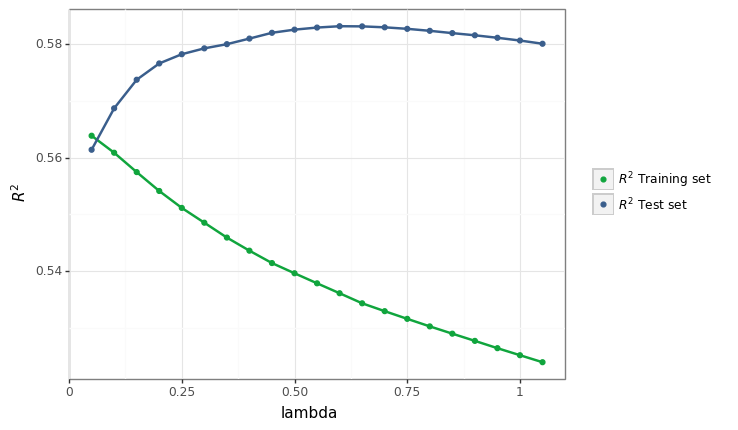

<ggplot: (675850030)>

In [50]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25}, legend_title=element_blank())
)


In [51]:
df_lam = pd.DataFrame(test_r_squared * 100, columns=["R_squared"])
df_lam["lambda"] = lambdas
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam["R_squared"].idxmax()]


R_squared    58.318337
lambda        0.600000
Name: 11, dtype: float64

In [52]:
reg_best = Lasso(alpha=df_lam.loc[df_lam["R_squared"].idxmax()]["lambda"])
reg_best.fit(X_train, y_train)


Lasso(alpha=0.6)

In [53]:
reg_best.coef_[reg_best.coef_ > 0]


array([ 3.70109995,  6.87271689,  1.68235845, 17.62780695,  0.77287977,
        0.11982064,  1.32596211,  0.24746857,  0.45555656,  1.48414325,
        0.58318473,  0.32242183,  1.72930523,  0.32264369,  0.31803136,
        0.31023783,  0.48910135,  1.29722389,  0.0202247 ,  0.93667709,
        0.14388706,  1.60267385,  0.15129995,  1.44117777,  0.32886947,
        0.30222494,  2.81442224,  0.78037226,  0.91677915,  2.18686682,
        1.25337437,  3.94260092,  2.50573087,  0.6805505 ])

In [54]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))


1019.0419301725435

In [55]:
y, X = patsy.dmatrices("price" + vars_model_8, data)


In [56]:
from sklearn.model_selection import GridSearchCV

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)


In [57]:
print("RMSE: " + str(results.best_score_ * -1))


RMSE: 36.64882232931602


In [58]:
results


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=Lasso(),
             param_grid={'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_root_mean_squared_error')

### Part3

#### Model diagnostics

In [59]:
model3_level = smf.ols("price" + modellev3, data=data_work).fit(cov_type="HC0")
model7_level = smf.ols("price" + modellev7, data=data_work).fit(cov_type="HC0")


In [60]:
# look at holdout RMSE
rmse_data = pd.concat(
    [data_work["price"], model7_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)
rmse_data = rmse_data[~rmse_data.isna().any(axis=1)]
model7_level_work_rmse = rmse(rmse_data["price"], rmse_data["predicted"], axis=0)
rmse_data = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
rmse_data = rmse_data[~rmse_data.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(rmse_data["price"], rmse_data["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{round(model7_level_holdout_rmse,2)}",
)


RMSE work:36.02 	 RMSE holdout:37.37


### Fitted vs actual outcome

In [61]:
Ylev = data_holdout["price"]
meanY = Ylev.mean()
sdY = Ylev.std()
meanY_m2SE = meanY - 1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p = Ylev.quantile(0.05)
Y95p = Ylev.quantile(0.95)


Create data frame with the real and predicted values

In [62]:
dt = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)
data_extra = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
data_extra = data_extra[~data_extra.isna().any(axis=1)].reset_index(drop=True)
dt["Ylev"] = data_extra["price"]


### Figure 14.8 Airbnb prediction – model diagnostics

(a) Predicted price vs. actual price

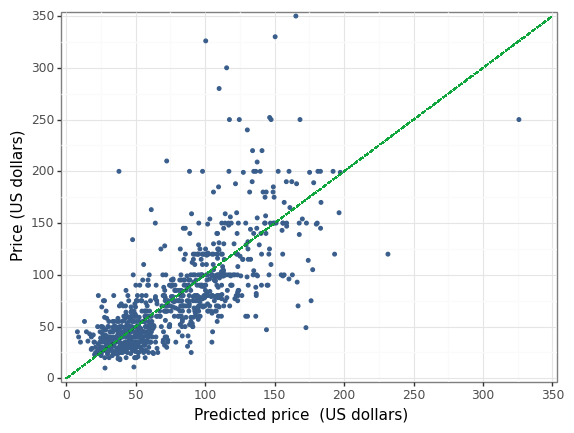

<ggplot: (674967345)>

In [63]:
(
    ggplot(data=dt)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[0],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(
        aes(x=0, y=0, xend=350, yend=350), size=0.5, linetype="dashed", color=color[1]
    )
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)


In [64]:
# Redo predicted values at 80% PI
dt = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.2)
data_extra = pd.concat(
    [
        data_holdout["price"],
        data_holdout["n_accommodates"],
        model7_level.predict(data_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
data_extra = data_extra[~data_extra.isna().any(axis=1)].reset_index(drop=True)
dt["n_accommodates"] = data_extra["n_accommodates"]
dt["Ylev"] = data_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]


In [65]:
predictionlev_holdout_summary = dt.groupby(by=["n_accommodates"]).mean().reset_index()


(b) Prediction interval by size

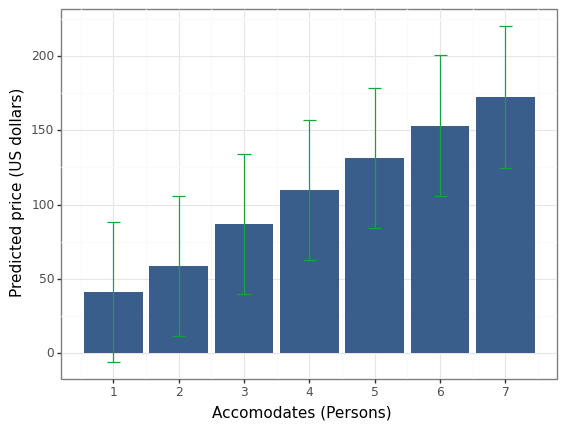

<ggplot: (685299450)>

In [66]:
(
    ggplot(predictionlev_holdout_summary, aes(x="n_accommodates"))
    + geom_bar(aes(y="mean"), stat="identity", fill=color[0], alpha=0.7)
    + geom_errorbar(
        aes(ymin="obs_ci_lower", ymax="obs_ci_upper"), color=color[1], width=0.2
    )
    + scale_y_continuous(name="Predicted price (US dollars)")
    + scale_x_continuous(name="Accomodates (Persons)", breaks=seq(1, 7, 1))
    + scale_color_manual(values=(color[1], color[1]))
    + theme_bw()
    + theme(legend_title=element_blank(), legend_position="none")
)

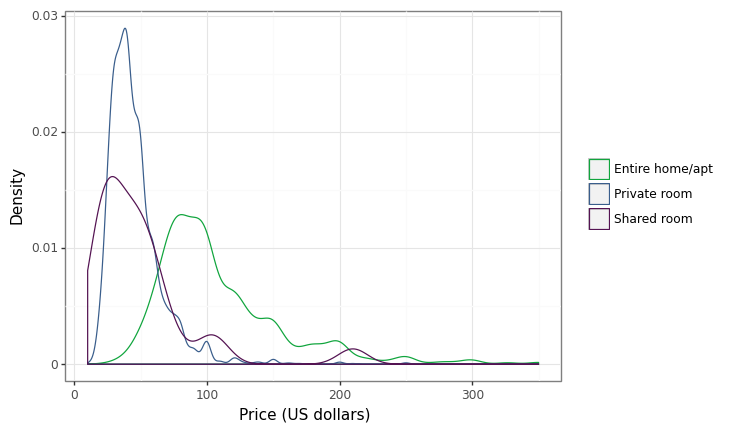

<ggplot: (685339691)>

In [67]:
# Density chart (not in book)
(
    ggplot(datau, aes(x="price", color="factor(f_room_type)"))
    + geom_density(na_rm=True, alpha=0.3)
    + scale_color_manual(name="", values=(color[1], color[0], color[2]))
    + labs(x="Price (US dollars)", y="Density", color="")
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title=element_blank(),
        legend_direction="vertical",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)

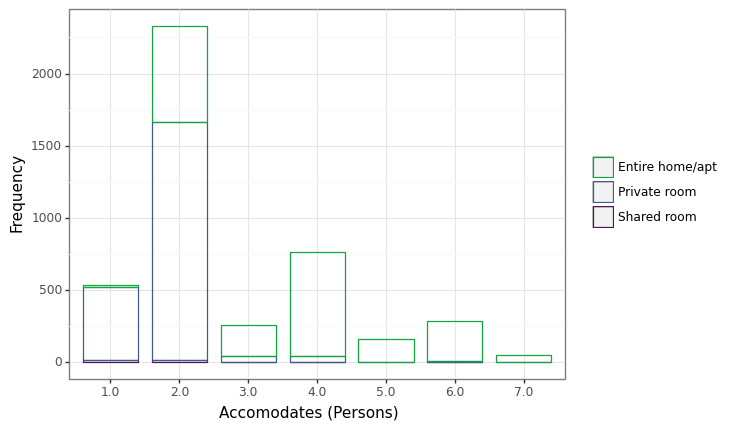

<ggplot: (674887741)>

In [68]:
# Barchart  (not in book)
(
    ggplot(datau, aes(x="factor(n_accommodates)", color="f_room_type"))
    + geom_bar(alpha=0.8, na_rm=True, width=0.8, fill=None)
    + scale_color_manual(name="", values=(color[1], color[0], color[2]))
    + labs(x="Accomodates (Persons)", y="Frequency")
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title=element_blank(),
        legend_direction="vertical",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)